# Refine the 16 NREL5MW turbine domain

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm
import shutil
import yaml

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [3]:
rundir = '/ccs/proj/cfd162/lcheung/ALCC_Frontier_WindFarm/farmruns/16_turb_abl_fsi/16_turb_abl_alm_BD_FY24Q3/'
fsidir = '/lustre/orion/cfd162/proj-shared/lcheung/ALCC_Frontier_WindFarm/windfarm/test/exawind-cases/16_turb_abl_fsi/run_refinedomain'
originalinput = 'nrel5mw_amr.inp'
outputfile    = 'nrel5mw_amr_alm.inp'

In [4]:
# Go to the run directory
#if not os.path.exists(rundir):
#    os.makedirs(rundir)
if os.path.exists(rundir):
    shutil.rmtree(rundir)
os.makedirs(rundir)

In [5]:
# Load the starting point
# This assumes that rundir was already set up with setup.sh (see https://github.com/Exawind/exawind-cases/blob/main/16_turb_abl_fsi/setup.sh)
os.chdir(fsidir)
case.loadAMRWindInput(originalinput)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict([('time.plot_start', '30000'),
             ('BoussinesqBuoyancy.read_temperature_profile', 'true'),
             ('BoussinesqBuoyancy.tprofile_filename',
              '/lustre/orion/proj-shared/cfd162/shared/avg_theta.dat'),
             ('CoriolisForcing.turn_off_vertical_force', 'True'),
             ('ABL.inflow_outflow_mode', 'true'),
             ('ABL.wf_velocity', '6.093275678667113 3.659473797517521'),
             ('ABL.wf_vmag', '7.12794309269604'),
             ('ABL.wf_theta', '300.2026467204779'),
             ('ABL.enable_hybrid_rl_mode', 'true'),
             ('amr.max_grid_size', '128'),
             ('amr.blocking_factor', '32'),
             ('nodal_proj.max_coarsening_level', '0'),
             ('nodal_proj.num_pre_smooth', '10'),
             ('nodal_proj.num_post_smooth', '10'),
             ('nodal_proj.bottom_rtol', '1.0e-9'),
             ('nodal_proj.bottom_atol', '1.0e-12'),
             ('mac_proj.verbose', '0'),
             ('mac_proj.max_coar

In [6]:
# Load the turbine locations
yamlfile = 'inp.yaml'
with open(yamlfile, 'r') as f:
    data = yaml.load(f, Loader=yaml.SafeLoader)

Nturbs=data['n_turbines_glob']

In [7]:
turbbase_xy = []
for i in range(Nturbs):
    turbbase_xy.append(data['turbine_info']['turb'+repr(i)]['turbine_base_pos'])

In [8]:
# Build the CSV input file of turbine layouts for amrwind-frontend
OFdt = 0.0008608815426997245
OFoptions=(
           "FSTparam_CompServo:0 "
           "FSTparam_DT:0.0008608815426997245 "
           "AMRparam_Actuator_epsilon:[4.41;4.41;4.41] "
           "AMRparam_Actuator_epsilon_tower:[4.41;4.41;4.41] "
           "AMRparam_Actuator_openfast_stop_time:3000.0 "
          )
#"ADparam_TwrAero:False ADparam_TwrShadow:0 ADparam_TwrPotent:0 "

turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
"""
rowformat="T%i, %f, %f, NREL5MW_FSI, 240.0, ,%s\n"
for iturb, xy in enumerate(turbbase_xy):
    turboptions  = OFoptions
    # uncomment this line for AWC
    #if iturb < 3:   turboptions += AWCoptions
    turbinescsv += rowformat%(iturb, xy[0], xy[1], turboptions)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)
#print(turbinescsv)

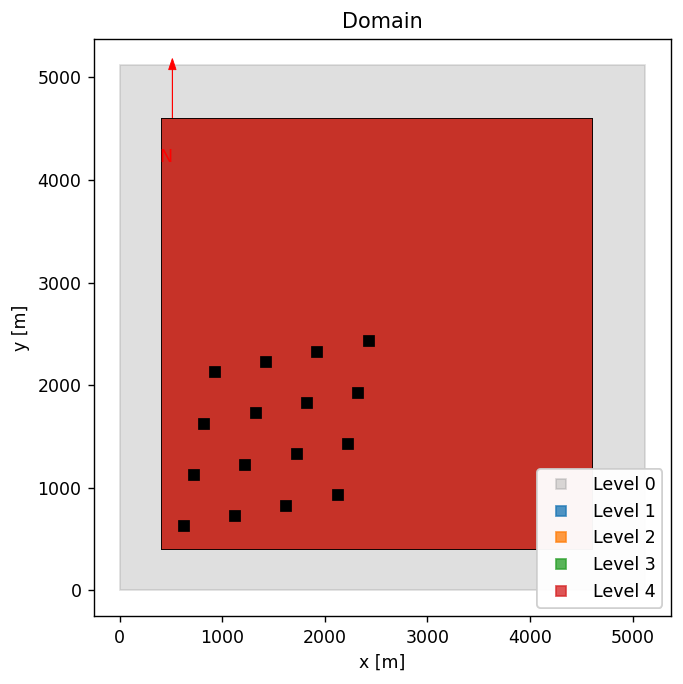

In [9]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #['p_hub']
case.plotDomain(ax=ax)
for iturb, xy in enumerate(turbbase_xy):
    ax.plot(xy[0], xy[1], 'ks')

In [10]:
case.estimateMeshSize()

 box 0 level 1: 42336000 cells
 box 0 level 2: 338688000 cells
 box 0 level 3: 2709504000 cells
 box 0 level 4: 21676032000 cells
ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0     50331648             10.0 x 10.0 x 10.0
       1     42336000                5.0 x 5.0 x 5.0
       2    338688000                2.5 x 2.5 x 2.5
       3   2709504000             1.25 x 1.25 x 1.25
       4  21676032000          0.625 x 0.625 x 0.625
  TOTAL:  24816891648


In [11]:
os.chdir(rundir)

In [12]:
case.setAMRWindInput('turbines_deleteprev', True)
case.setAMRWindInput('turbines_createnewdomain', False)

case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/amrwind-frontend/turbines/OpenFAST3p4_BD_NREL5MW to T0_OpenFAST3p4_BD_NREL5MW
T0_OpenFAST3p4_BD_NREL5MW/nrel5mw.fst
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('CompServo', 0), ('DT', 0.0008608815426997245)])
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/amrwind-frontend/turbines/OpenFAST3p4_BD_NREL5MW to T1_OpenFAST3p4_BD_NREL5MW


0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         0 CompServo - Compute control and electrical-drive dynamics (switch) {0=None 1=ServoDyn} [EDITED]
0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         0 CompServo - Compute control and electrical-drive dynamics (switch) {0=None 1=ServoDyn} [EDITED]


T1_OpenFAST3p4_BD_NREL5MW/nrel5mw.fst
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('CompServo', 0), ('DT', 0.0008608815426997245)])
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/amrwind-frontend/turbines/OpenFAST3p4_BD_NREL5MW to T2_OpenFAST3p4_BD_NREL5MW
T2_OpenFAST3p4_BD_NREL5MW/nrel5mw.fst
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('CompServo', 0), ('DT', 0.0008608815426997245)])
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/amrwind-frontend/turbines/OpenFAST3p4_BD_NREL5MW to T3_OpenFAST3p4_BD_NREL5MW
T3_OpenFAST3p4_BD_NREL5MW/nrel5mw.fst
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('CompServo', 0), ('DT', 0.000860881542

0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         0 CompServo - Compute control and electrical-drive dynamics (switch) {0=None 1=ServoDyn} [EDITED]
0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         0 CompServo - Compute control and electrical-drive dynamics (switch) {0=None 1=ServoDyn} [EDITED]


T4_OpenFAST3p4_BD_NREL5MW/nrel5mw.fst
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('CompServo', 0), ('DT', 0.0008608815426997245)])
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/amrwind-frontend/turbines/OpenFAST3p4_BD_NREL5MW to T5_OpenFAST3p4_BD_NREL5MW
T5_OpenFAST3p4_BD_NREL5MW/nrel5mw.fst
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('CompServo', 0), ('DT', 0.0008608815426997245)])
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/amrwind-frontend/turbines/OpenFAST3p4_BD_NREL5MW to T6_OpenFAST3p4_BD_NREL5MW


0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         0 CompServo - Compute control and electrical-drive dynamics (switch) {0=None 1=ServoDyn} [EDITED]
0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         0 CompServo - Compute control and electrical-drive dynamics (switch) {0=None 1=ServoDyn} [EDITED]


T6_OpenFAST3p4_BD_NREL5MW/nrel5mw.fst
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('CompServo', 0), ('DT', 0.0008608815426997245)])
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/amrwind-frontend/turbines/OpenFAST3p4_BD_NREL5MW to T7_OpenFAST3p4_BD_NREL5MW
T7_OpenFAST3p4_BD_NREL5MW/nrel5mw.fst
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('CompServo', 0), ('DT', 0.0008608815426997245)])
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/amrwind-frontend/turbines/OpenFAST3p4_BD_NREL5MW to T8_OpenFAST3p4_BD_NREL5MW


0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         0 CompServo - Compute control and electrical-drive dynamics (switch) {0=None 1=ServoDyn} [EDITED]
0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         0 CompServo - Compute control and electrical-drive dynamics (switch) {0=None 1=ServoDyn} [EDITED]


T8_OpenFAST3p4_BD_NREL5MW/nrel5mw.fst
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('CompServo', 0), ('DT', 0.0008608815426997245)])
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/amrwind-frontend/turbines/OpenFAST3p4_BD_NREL5MW to T9_OpenFAST3p4_BD_NREL5MW
T9_OpenFAST3p4_BD_NREL5MW/nrel5mw.fst
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('CompServo', 0), ('DT', 0.0008608815426997245)])
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/amrwind-frontend/turbines/OpenFAST3p4_BD_NREL5MW to T10_OpenFAST3p4_BD_NREL5MW


0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         0 CompServo - Compute control and electrical-drive dynamics (switch) {0=None 1=ServoDyn} [EDITED]
0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         0 CompServo - Compute control and electrical-drive dynamics (switch) {0=None 1=ServoDyn} [EDITED]


T10_OpenFAST3p4_BD_NREL5MW/nrel5mw.fst
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('CompServo', 0), ('DT', 0.0008608815426997245)])
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/amrwind-frontend/turbines/OpenFAST3p4_BD_NREL5MW to T11_OpenFAST3p4_BD_NREL5MW
T11_OpenFAST3p4_BD_NREL5MW/nrel5mw.fst
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('CompServo', 0), ('DT', 0.0008608815426997245)])


0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         0 CompServo - Compute control and electrical-drive dynamics (switch) {0=None 1=ServoDyn} [EDITED]
0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         0 CompServo - Compute control and electrical-drive dynamics (switch) {0=None 1=ServoDyn} [EDITED]


docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/amrwind-frontend/turbines/OpenFAST3p4_BD_NREL5MW to T12_OpenFAST3p4_BD_NREL5MW
T12_OpenFAST3p4_BD_NREL5MW/nrel5mw.fst
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('CompServo', 0), ('DT', 0.0008608815426997245)])
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/amrwind-frontend/turbines/OpenFAST3p4_BD_NREL5MW to T13_OpenFAST3p4_BD_NREL5MW


0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         0 CompServo - Compute control and electrical-drive dynamics (switch) {0=None 1=ServoDyn} [EDITED]
0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         0 CompServo - Compute control and electrical-drive dynamics (switch) {0=None 1=ServoDyn} [EDITED]


T13_OpenFAST3p4_BD_NREL5MW/nrel5mw.fst
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('CompServo', 0), ('DT', 0.0008608815426997245)])
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/amrwind-frontend/turbines/OpenFAST3p4_BD_NREL5MW to T14_OpenFAST3p4_BD_NREL5MW
T14_OpenFAST3p4_BD_NREL5MW/nrel5mw.fst
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('CompServo', 0), ('DT', 0.0008608815426997245)])
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/amrwind-frontend/turbines/OpenFAST3p4_BD_NREL5MW to T15_OpenFAST3p4_BD_NREL5MW
T15_OpenFAST3p4_BD_NREL5MW/nrel5mw.fst
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('CompServo', 0), ('DT', 0.0008608

0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         0 CompServo - Compute control and electrical-drive dynamics (switch) {0=None 1=ServoDyn} [EDITED]
0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         0 CompServo - Compute control and electrical-drive dynamics (switch) {0=None 1=ServoDyn} [EDITED]


In [13]:
## Add refinement zones
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     2160,     2160,       2160,    90,   200,   center:specified units:meter orientation:x centerx:2560 centery:2560 centerz:90 name:level1
1,     1600,     1600,       1600,    90,   200,   center:specified units:meter orientation:x centerx:2000 centery:2000 centerz:90 name:level2
#2,     1.25,     2.0,        1.25,  0.75,   1.0, 
#3,     0.75,     0.75,       1.00,  0.75,   0.75, 
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)
case.refine_createAllZones()

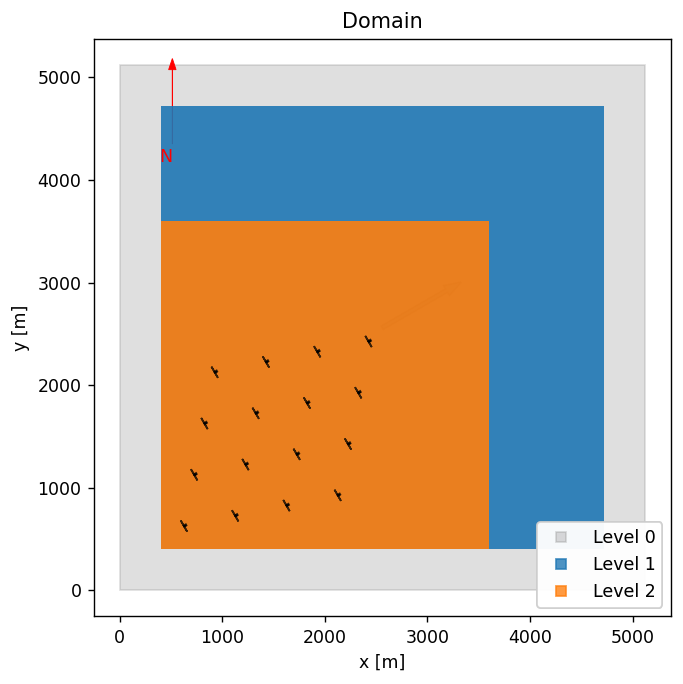

In [14]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #['p_hub']
case.plotDomain(ax=ax)

In [15]:
case.estimateMeshSize()

Refinement level1: level 1: 43296768 cells
Refinement level2: level 2: 190054400 cells
ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0     50331648             10.0 x 10.0 x 10.0
       1     43296768                5.0 x 5.0 x 5.0
       2    190054400                2.5 x 2.5 x 2.5
  TOTAL:    283682816


## Add some sampling planes

In [16]:
outputoptions="outputvars:velocity;tke;temperature outputfreq:25"
samplingcsv="""
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
#cl1, centerline, 1,  0, none, none,  none,  11, 11, none
#rp1, rotorplane, 2,  0, none, none,  none,  11, 11, none
#sw1, streamwise, 2,  1, 1, 0.5,  0.5,  11, 11, usedx:0.25 noffsets:1
turbsw,    streamwise, 4,        4,         2,      0.7,    1.5,     11, 11, usedx:0.05 outputto:turbsw_ orientation:nacdir {outputoptions} noffsets:0
turbhh,    hubheight,  4,        4,         2,       0,     1.5,     11, 11, usedx:0.05 outputto:turbhh_ orientation:nacdir {outputoptions} noffsets:0
turbdomain,hubheight,  8,        8,         2,       0,     126,     11, 11, units:meter usedx:16 outputto:turbdomain_ orientation:nacdir center:farm wholedomain:1  {outputoptions} noffsets:1
""".format(outputoptions=outputoptions)

case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', True)

In [17]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['T0_turbsw', 'T1_turbsw', 'T2_turbsw', 'T3_turbsw', 'T4_turbsw', 'T5_turbsw', 'T6_turbsw', 'T7_turbsw', 'T8_turbsw', 'T9_turbsw', 'T10_turbsw', 'T11_turbsw', 'T12_turbsw', 'T13_turbsw', 'T14_turbsw', 'T15_turbsw', 'T0_turbhh', 'T1_turbhh', 'T2_turbhh', 'T3_turbhh', 'T4_turbhh', 'T5_turbhh', 'T6_turbhh', 'T7_turbhh', 'T8_turbhh', 'T9_turbhh', 'T10_turbhh', 'T11_turbhh', 'T12_turbhh', 'T13_turbhh', 'T14_turbhh', 'T15_turbhh', 'Farm_turbdomain']


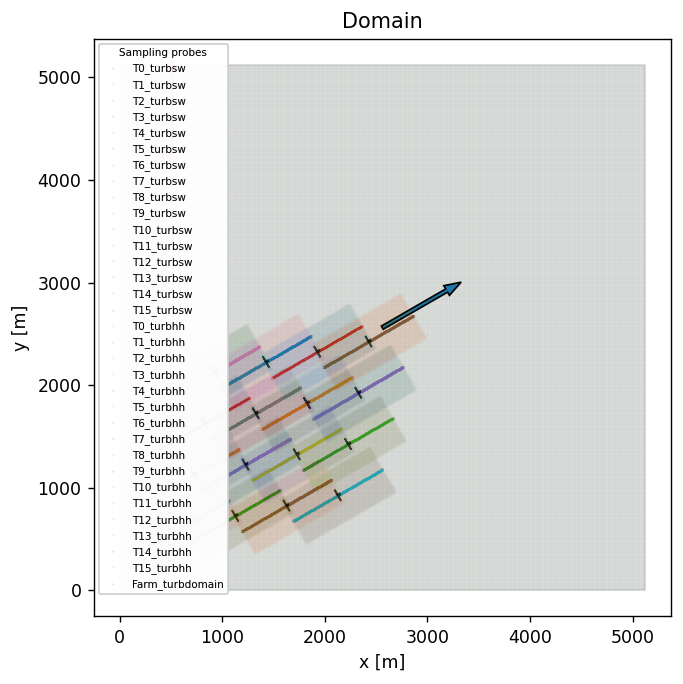

In [18]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':.1, 'marker':'.', 'linestyle':'None', 'alpha':0.1}"
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend']= "{'title':'Sampling probes', 'fontsize':6, 'loc':'upper left', 'markerscale':10}"
case.plotDomain(ax=ax)

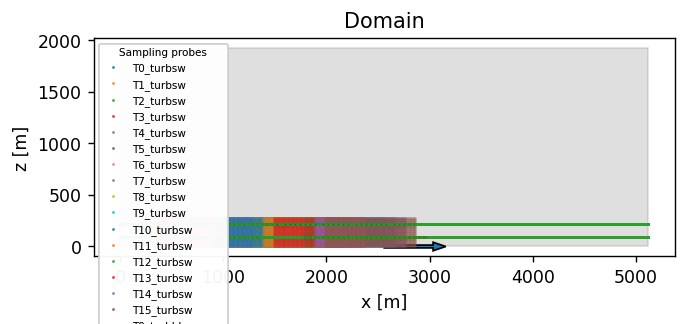

In [19]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':.1, 'marker':'.', 'linestyle':'None'}"
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XZ'
case.plotDomain(ax=ax)

In [20]:
## Fix any operating parameters
case.setAMRWindInput('time.fixed_dt', OFdt*20)
case.setAMRWindInput('time.stop_time', 15000+2000.0)

In [21]:
## Create a version without turbines
#case.removeturbines()
inputfile=case.writeAMRWindInput(outputfile)
print(inputfile)

# --- Simulation time control parameters ---
time.stop_time                           = 17000.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.01721763085399449 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = -1                  
incflo.physics                           = ABL Actuator        # List of physics models to include in simulation.
incflo.verbose                           = 0                   
io.check_file                            = chk                 
io.restart_file                          = /lustre/orion/proj-shared/cfd162/shared/chk30000
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84        
TKE.source_terms                         = KsgsM84Src          
nod